In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from datetime import datetime
from arch.unitroot import PhillipsPerron

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
sys.path

['',
 '/anaconda3/lib/python36.zip',
 '/anaconda3/lib/python3.6',
 '/anaconda3/lib/python3.6/lib-dynload',
 '/anaconda3/lib/python3.6/site-packages',
 '/anaconda3/lib/python3.6/site-packages/aeosa',
 '/Users/mate_toth/Projects/Python/oreilly_pytest/adv_pytest_mar_22_2018/block',
 '/Users/mate_toth/Projects/Python/oreilly_pytest/adv_pytest_mar_22_2018/skilift',
 '/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/Users/mate_toth/.ipython']

In [5]:
data_in = os.path.join(str(base_dir) , "da_data_repo/stocks-sp500/raw/")

In [6]:
data_out = os.path.join(str(base_dir), "da_data_repo/stocks-sp500/clean/")

In [7]:
output = os.path.join(str(base_dir), "da_case_studies/ch12-stock-returns-risk/output/")

In [8]:
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [9]:
sys.path.append(func)

In [10]:
from py_helper_functions import *

In [11]:
stock_data = pd.read_csv(os.path.join(data_in,"ready_sp500_45_cos.csv"))

In [12]:
stock_data.head()

,ticker,ref.date,price.open,price.close,price.adjusted,price.low,price.high,volume
0,ACN,2001-07-19,15.10,15.17,11.497672,15.00,15.29,34994300.0
1,ACN,2001-07-20,15.05,15.01,11.376402,14.80,15.05,9238500.0
2,ACN,2001-07-23,15.00,15.00,11.368821,14.55,15.01,7501000.0
3,ACN,2001-07-24,14.95,14.86,11.262713,14.70,14.97,3537300.0
4,ACN,2001-07-25,14.70,14.95,11.330926,14.65,14.95,4208100.0


In [13]:
MSFT = stock_data[stock_data['ticker']=='MSFT']

In [14]:
p_MSFT = MSFT[['ref.date','price.close']]. \
rename(columns={'ref.date':'date'}). \
reset_index(drop=True)

In [15]:
p_MSFT['date']=pd.to_datetime(p_MSFT['date'])

In [16]:
p_MSFT.head()

,date,price.close
0,1997-12-29,15.789063
1,1997-12-30,16.281250
2,1997-12-31,16.156250
3,1998-01-02,16.390625
4,1998-01-05,16.296875


In [17]:
sp500_index = pd.read_csv(os.path.join(data_in,"ready_sp500_index.csv"))

In [18]:
p_SP500 = sp500_index[['ref.date','price.close']]. \
rename(columns={'ref.date':'date'}). \
reset_index(drop=True)

In [19]:
p_SP500['date']=pd.to_datetime(p_SP500['date'])

In [20]:
data_daily=pd.merge(p_SP500,p_MSFT,how='inner',on='date').\
rename(columns={'price.close_x':'p_SP500','price.close_y':'p_MSFT'})

In [21]:
data_daily = data_daily[(data_daily['date']>='1997-12-31') & \
           (data_daily['date']<='2018-12-31')] 

In [22]:
data_daily['year'] = data_daily['date'].dt.year

In [23]:
data_daily['month'] = data_daily['date'].dt.month

In [24]:
#data_daily.to_csv(os.path.join(data_out,"stock-prices-daily.csv"))

In [25]:
# PART I: Graphs

In [26]:
data_daily['lnp_MSFT']=data_daily['p_MSFT'].map(lambda x:np.log(x))

In [27]:
data_daily['lnp_SP500']=data_daily['p_SP500'].map(lambda x:np.log(x))

In [28]:
limits = datetime(1998, 1, 1), datetime(2018, 1, 1)

In [29]:
breaks = date_breaks('2 year')

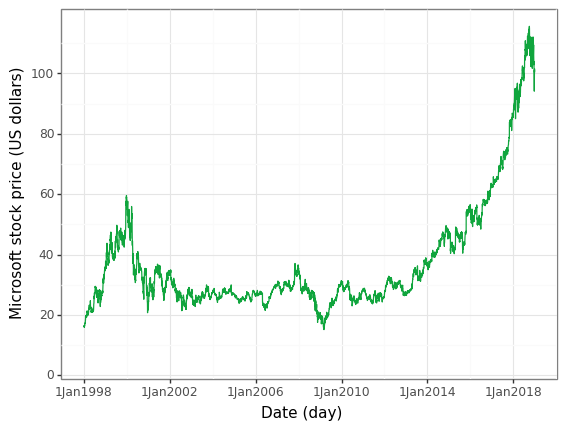

<ggplot: (-9223372036568149900)>

In [30]:
(ggplot(data_daily) 
  + geom_line(aes('date','p_MSFT'),color = color[1], size = 0.5) 
  + scale_y_continuous(expand = [0.01,0.01],limits = [0,120], breaks = seq(0,120,20)) 
  + scale_x_date(breaks = breaks(limits)[::2], labels = date_format("1%b%Y")) 
  + labs(y = "Microsoft stock price (US dollars)",x= "Date (day)") 
  + theme_bw())

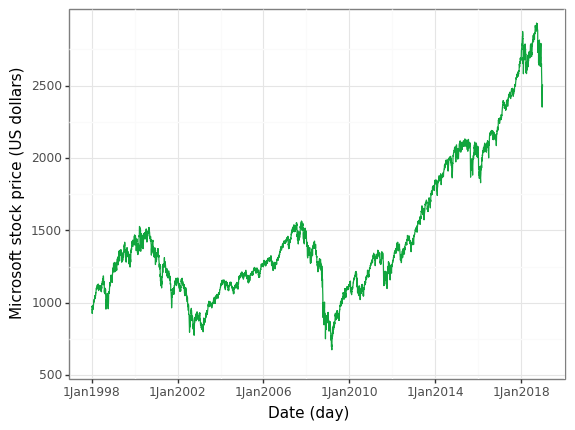

<ggplot: (-9223372036543251221)>

In [31]:
(ggplot(data_daily) 
  + geom_line(aes('date','p_SP500'),color = color[1], size = 0.5) 
  + scale_y_continuous(expand = [0.01,0.01],limits = [500,3000], breaks = seq(500,3000,500)) 
  + scale_x_date(breaks = breaks(limits)[::2], labels = date_format("1%b%Y")) 
  + labs(y = "Microsoft stock price (US dollars)",x= "Date (day)") 
  + theme_bw())

In [32]:
from arch.unitroot import PhillipsPerron

In [33]:
print(PhillipsPerron(data_daily['p_MSFT'],lags=32,test_type='rho',trend='n'))
print(PhillipsPerron(data_daily['p_MSFT'],lags=32,test_type='rho',trend='c'))
print(PhillipsPerron(data_daily['p_MSFT'],lags=32,test_type='rho',trend='ct'))

     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.287
P-value                         0.994
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.245
P-value                         0.998
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.092
P-value                         0.995
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%),

In [34]:
print(PhillipsPerron(data_daily['p_SP500'],lags=32,test_type='rho',trend='n'))
print(PhillipsPerron(data_daily['p_SP500'],lags=32,test_type='rho',trend='c'))
print(PhillipsPerron(data_daily['p_SP500'],lags=32,test_type='rho',trend='ct'))

     Phillips-Perron Test (Z-rho)    
Test Statistic                  0.908
P-value                         0.892
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.292
P-value                         0.940
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -3.943
P-value                         0.894
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%),

In [35]:
data_daily['l.p_MSFT'] = data_daily['p_MSFT'].shift()
data_daily['l.p_SP500'] = data_daily['p_SP500'].shift()
data_daily['d.p_MSFT'] = data_daily['p_MSFT'] - data_daily['l.p_MSFT']
data_daily['d.p_SP500'] = data_daily['p_SP500'] - data_daily['l.p_SP500']
data_daily['PctRetMSFT'] = data_daily['d.p_MSFT']/data_daily['l.p_MSFT']*100
data_daily['PctRetSP500'] = data_daily['d.p_SP500']/data_daily['l.p_SP500']*100

In [36]:
data_monthly = data_daily[['date','year','month','p_SP500','p_MSFT']].\
groupby(data_daily['date'].dt.to_period('M')).last().reset_index(drop=True)

In [37]:
data_monthly

,date,year,month,p_SP500,p_MSFT
0,1997-12-31,1997,12,970.429993,16.156250
1,1998-01-30,1998,1,980.280029,18.648438
2,1998-02-27,1998,2,1049.339966,21.187500
3,1998-03-31,1998,3,1101.750000,22.375000
4,1998-04-30,1998,4,1111.750000,22.531250
...,...,...,...,...,...
248,2018-08-31,2018,8,2901.520020,112.330002
249,2018-09-28,2018,9,2913.979980,114.370003
250,2018-10-31,2018,10,2711.739990,106.809998
251,2018-11-30,2018,11,2760.169922,110.889999


In [38]:
data_monthly['l.p_MSFT'] = data_monthly['p_MSFT'].shift()
data_monthly['l.p_SP500'] = data_monthly['p_SP500'].shift()
data_monthly['d.p_MSFT'] = data_monthly['p_MSFT'] - data_monthly['l.p_MSFT']
data_monthly['d.p_SP500'] = data_monthly['p_SP500'] - data_monthly['l.p_SP500']
data_monthly['PctRetMSFT'] = data_monthly['d.p_MSFT']/data_monthly['l.p_MSFT']*100
data_monthly['PctRetSP500'] = data_monthly['d.p_SP500']/data_monthly['l.p_SP500']*100

In [39]:
data_monthly['d.lnp_MSFT'] = np.log(data_monthly['p_MSFT']) - np.log(data_monthly['p_MSFT'].shift())
data_monthly['d.lnp_SP500'] = np.log(data_monthly['p_SP500']) - np.log(data_monthly['p_SP500'].shift())

In [40]:
data_daily.head()

,date,p_SP500,p_MSFT,year,month,lnp_MSFT,lnp_SP500,l.p_MSFT,l.p_SP500,d.p_MSFT,d.p_SP500,PctRetMSFT,PctRetSP500
2,1997-12-31,970.429993,16.156250,1997,12,2.782307,6.877739,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-01-02,975.039978,16.390625,1998,1,2.796710,6.882478,16.156250,970.429993,0.234375,4.609985,1.450677,0.475046
4,1998-01-05,977.070007,16.296875,1998,1,2.790973,6.884558,16.390625,975.039978,-0.093750,2.030029,-0.571973,0.208200
5,1998-01-06,966.580017,16.390625,1998,1,2.796710,6.873764,16.296875,977.070007,0.093750,-10.489990,0.575264,-1.073617
6,1998-01-07,964.000000,16.195313,1998,1,2.784722,6.871091,16.390625,966.580017,-0.195312,-2.580017,-1.191608,-0.266922


In [41]:
data_monthly.head()

,date,year,month,p_SP500,p_MSFT,l.p_MSFT,l.p_SP500,d.p_MSFT,d.p_SP500,PctRetMSFT,PctRetSP500,d.lnp_MSFT,d.lnp_SP500
0,1997-12-31,1997,12,970.429993,16.156250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-01-30,1998,1,980.280029,18.648438,16.156250,970.429993,2.492188,9.850036,15.425535,1.015018,0.143455,0.010099
2,1998-02-27,1998,2,1049.339966,21.187500,18.648438,980.280029,2.539062,69.059937,13.615414,7.044919,0.127649,0.068078
3,1998-03-31,1998,3,1101.750000,22.375000,21.187500,1049.339966,1.187500,52.410034,5.604720,4.994571,0.054533,0.048738
4,1998-04-30,1998,4,1111.750000,22.531250,22.375000,1101.750000,0.156250,10.000000,0.698324,0.907647,0.006959,0.009036


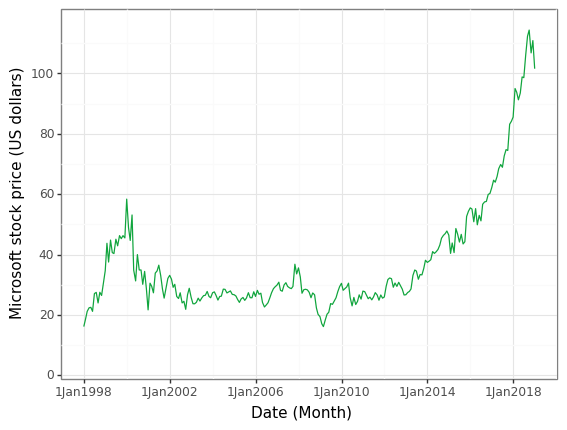

<ggplot: (-9223372036543213063)>

In [42]:
(ggplot(data_monthly) 
  + geom_line(aes('date','p_MSFT'),color = color[1], size = 0.5) 
  + scale_y_continuous(expand = [0.01,0.01],limits = [0,120], breaks = seq(0,120,20)) 
  + scale_x_date(breaks = breaks(limits)[::2], labels = date_format("1%b%Y")) 
  + labs(y = "Microsoft stock price (US dollars)",x= "Date (Month)") 
  + theme_bw())

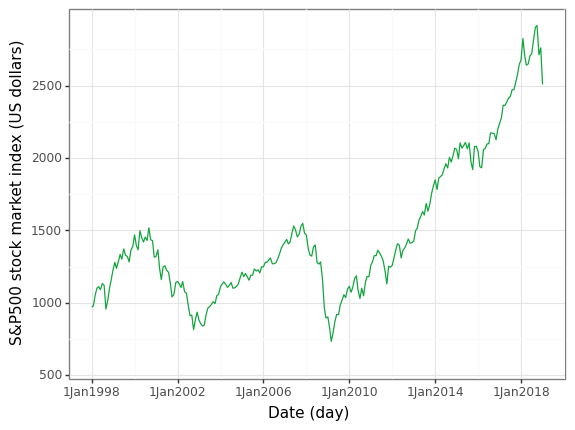

<ggplot: (311522445)>

In [43]:
(ggplot(data_monthly) 
  + geom_line(aes('date','p_SP500'),color = color[1], size = 0.5) 
  + scale_y_continuous(expand = [0.01,0.01],limits = [500,3000], breaks = seq(500,3000,500)) 
  + scale_x_date(breaks = breaks(limits)[::2], labels = date_format("1%b%Y")) 
  + labs(y = "S&P500 stock market index (US dollars)",x= "Date (day)") 
  + theme_bw())

In [44]:
print(PhillipsPerron(data_daily['p_MSFT'],lags=32,test_type='rho',trend='n'))
print(PhillipsPerron(data_daily['p_MSFT'],lags=32,test_type='rho',trend='c'))
print(PhillipsPerron(data_daily['p_MSFT'],lags=32,test_type='rho',trend='ct'))

     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.287
P-value                         0.994
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.245
P-value                         0.998
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.092
P-value                         0.995
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%),

In [45]:
print(PhillipsPerron(data_daily['p_SP500'],lags=32,test_type='rho',trend='n'))
print(PhillipsPerron(data_daily['p_SP500'],lags=32,test_type='rho',trend='c'))
print(PhillipsPerron(data_daily['p_SP500'],lags=32,test_type='rho',trend='ct'))

     Phillips-Perron Test (Z-rho)    
Test Statistic                  0.908
P-value                         0.892
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.292
P-value                         0.940
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -3.943
P-value                         0.894
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%),

/anaconda3/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


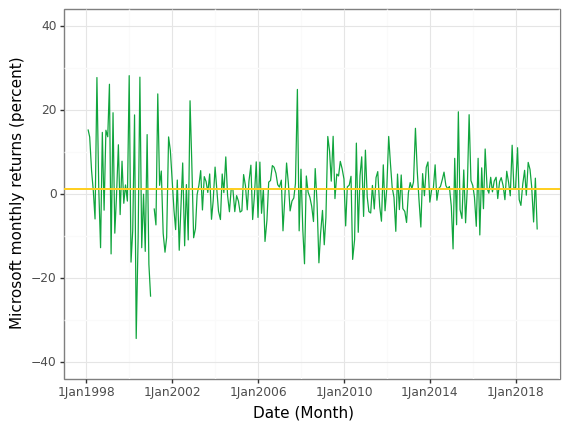

<ggplot: (311857647)>

In [46]:
(ggplot(data_monthly) 
  + geom_line(aes('date','PctRetMSFT'),color = color[1], size = 0.5) 
  + scale_x_date(breaks = breaks(limits)[::2], labels = date_format("1%b%Y")) 
  + geom_hline(yintercept = 1.13,color=color[3], size=0.8) 
  + labs(y = "Microsoft monthly returns (percent)",x= "Date (Month)") 
  + ylim(-40,40) 
  + theme_bw())

/anaconda3/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


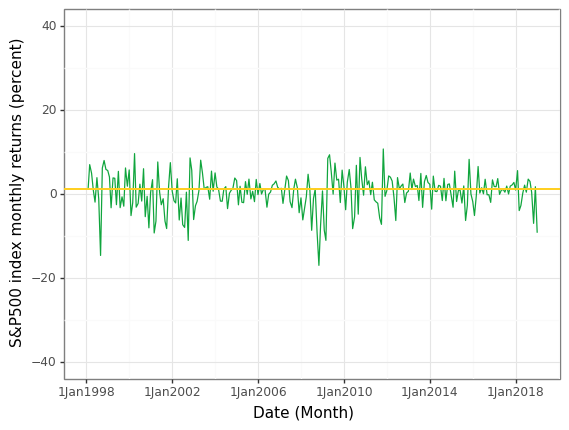

<ggplot: (-9223372036542878874)>

In [47]:
(ggplot(data_monthly) 
  + geom_line(aes('date','PctRetSP500'),color = color[1], size = 0.5) 
  + scale_x_date(breaks = breaks(limits)[::2], labels = date_format("1%b%Y")) 
  + geom_hline(yintercept = 1.13,color=color[3], size=0.8) 
  + labs(y = "S&P500 index monthly returns (percent)",x= "Date (Month)") 
  + ylim(-40,40) 
  + theme_bw())

In [48]:
data_monthly

,date,year,month,p_SP500,p_MSFT,l.p_MSFT,l.p_SP500,d.p_MSFT,d.p_SP500,PctRetMSFT,PctRetSP500,d.lnp_MSFT,d.lnp_SP500
0,1997-12-31,1997,12,970.429993,16.156250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-01-30,1998,1,980.280029,18.648438,16.156250,970.429993,2.492188,9.850036,15.425535,1.015018,0.143455,0.010099
2,1998-02-27,1998,2,1049.339966,21.187500,18.648438,980.280029,2.539062,69.059937,13.615414,7.044919,0.127649,0.068078
3,1998-03-31,1998,3,1101.750000,22.375000,21.187500,1049.339966,1.187500,52.410034,5.604720,4.994571,0.054533,0.048738
4,1998-04-30,1998,4,1111.750000,22.531250,22.375000,1101.750000,0.156250,10.000000,0.698324,0.907647,0.006959,0.009036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2018-08-31,2018,8,2901.520020,112.330002,106.080002,2816.290039,6.250000,85.229981,5.891780,3.026321,0.057247,0.029814
249,2018-09-28,2018,9,2913.979980,114.370003,112.330002,2901.520020,2.040001,12.459960,1.816078,0.429429,0.017998,0.004285
250,2018-10-31,2018,10,2711.739990,106.809998,114.370003,2913.979980,-7.560005,-202.239990,-6.610129,-6.940336,-0.068387,-0.071929
251,2018-11-30,2018,11,2760.169922,110.889999,106.809998,2711.739990,4.080001,48.429932,3.819868,1.785936,0.037487,0.017702


In [49]:
print(PhillipsPerron(data_monthly.loc[1:,'PctRetMSFT'],lags=5,test_type='rho',trend='n'))
print(PhillipsPerron(data_monthly.loc[1:,'PctRetMSFT'],lags=5,test_type='rho',trend='c'))
print(PhillipsPerron(data_monthly.loc[1:,'PctRetMSFT'],lags=5,test_type='rho',trend='ct'))

     Phillips-Perron Test (Z-rho)    
Test Statistic               -285.235
P-value                         0.000
Lags                                5
-------------------------------------

Trend: No Trend
Critical Values: -12.12 (1%), -7.03 (5%), -4.96 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -280.444
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -20.16 (1%), -13.86 (5%), -11.10 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -280.268
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -28.45 (1%),

In [50]:
print(PhillipsPerron(data_monthly.loc[1:,'PctRetSP500'],lags=5,test_type='rho',trend='n'))
print(PhillipsPerron(data_monthly.loc[1:,'PctRetSP500'],lags=5,test_type='rho',trend='c'))
print(PhillipsPerron(data_monthly.loc[1:,'PctRetSP500'],lags=5,test_type='rho',trend='ct'))

     Phillips-Perron Test (Z-rho)    
Test Statistic               -234.376
P-value                         0.000
Lags                                5
-------------------------------------

Trend: No Trend
Critical Values: -12.12 (1%), -7.03 (5%), -4.96 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -233.937
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -20.16 (1%), -13.86 (5%), -11.10 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -233.518
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -28.45 (1%),

In [51]:
data_monthly[['PctRetMSFT','PctRetSP500']].describe()

,PctRetMSFT,PctRetSP500
count,252.000000,252.000000
mean,1.134330,0.470715
std,9.074152,4.292603
min,-34.352941,-16.942452
25%,-3.994089,-1.792661
50%,1.309341,0.922754
75%,5.445887,3.208198
max,40.778098,10.772304


/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


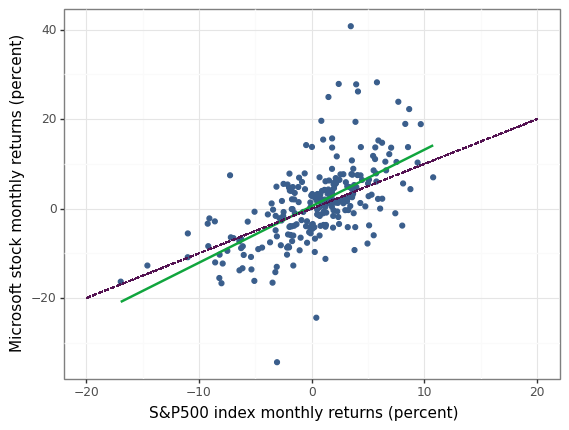

<ggplot: (-9223372036542875318)>

In [52]:
(ggplot(data_monthly,aes('PctRetSP500','PctRetMSFT'))
 + geom_point(color=color[0])
 + geom_smooth(method='lm',se=False,color=color[1])
 + labs(x="S&P500 index monthly returns (percent)",y="Microsoft stock monthly returns (percent)")
 + theme_bw()
 + geom_segment(aes(x = -20, y = -20, xend = 20, yend = 20), color=color[2], size=0.5, linetype="dashed")
)
 # geom_segment(aes(x = -20, y = -20, xend = 20, yend = 20), color=color[3], size=0.5, linetype="dashed")+
 # geom_segment(aes(x = 10, y = 0, xend = 17, yend = 17), arrow = arrow(length = unit(0.1, "cm")))+
 # annotate("text", x = 10, y = -3, size=2, label = "45 degree line for beta=1")+
 # geom_segment(aes(x = -10, y = -17, xend = -15, yend = -17), arrow = arrow(length = unit(0.1, "cm")))+
 # annotate("text", x = -5, y = -17, size=2, label = "reg line, beta=1.26")


In [53]:
data_monthly_tidy = pd.melt(data_monthly[['date','PctRetMSFT','PctRetSP500']],id_vars = ['date'],var_name='index', value_name='pct_return')

In [54]:
data_monthly_tidy

,date,index,pct_return
0,1997-12-31,PctRetMSFT,NaN
1,1998-01-30,PctRetMSFT,15.425535
2,1998-02-27,PctRetMSFT,13.615414
3,1998-03-31,PctRetMSFT,5.604720
4,1998-04-30,PctRetMSFT,0.698324
...,...,...,...
501,2018-08-31,PctRetSP500,3.026321
502,2018-09-28,PctRetSP500,0.429429
503,2018-10-31,PctRetSP500,-6.940336
504,2018-11-30,PctRetSP500,1.785936


/anaconda3/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 3 rows containing missing values.


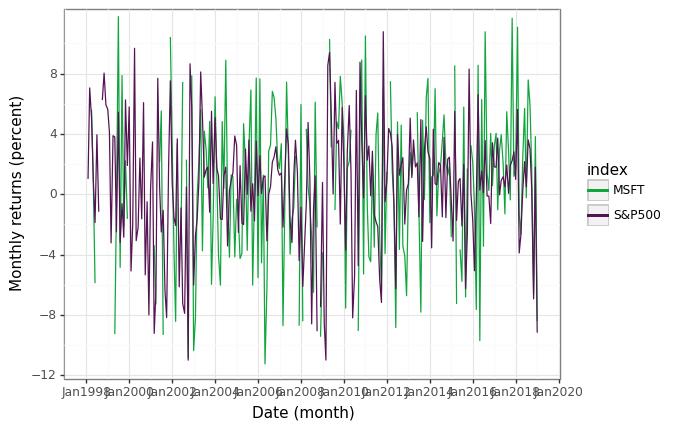

<ggplot: (311874652)>

In [55]:
(ggplot(data_monthly_tidy)
 + geom_line(aes(x='date',y = 'pct_return',color='index'),size = 0.5)
 + scale_color_manual(name = "", values=[color[1], color[2], color[3]], labels = ["MSFT", "S&P500"]) 
 + labs(x = 'Date (month)',y = "Monthly returns (percent)")
 + scale_y_continuous(expand = [0.01,0.01], limits = [-12,12], breaks = seq(-12,12,4)) 
 + scale_x_date(breaks = breaks, labels = date_format("%b%Y")) 
 + theme_bw()
)

In [56]:
#Regressions

In [ ]:
#NOTE: names including '.' like d.lnp_MSFT don't seem to work.
#Changed to d_lnp_MSFT

In [65]:
reg1 = smf.ols('PctRetMSFT ~ PctRetSP500', data=data_monthly).fit()
reg2 = smf.ols('d_lnp_MSFT ~ d_lnp_SP500',
               data=data_monthly.rename(columns={'d.lnp_MSFT':'d_lnp_MSFT','d.lnp_SP500':'d_lnp_SP500'})
              ).fit()
reg3 = smf.ols('PctRetMSFT ~ PctRetSP500', data=data_daily).fit()

In [66]:
print(reg1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:             PctRetMSFT   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     150.5
Date:                Sun, 04 Oct 2020   Prob (F-statistic):           2.14e-27
Time:                        16:41:20   Log-Likelihood:                -857.14
No. Observations:                 252   AIC:                             1718.
Df Residuals:                     250   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5396      0.453      1.191      

In [67]:
print(reg2.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:             d_lnp_MSFT   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     152.9
Date:                Sun, 04 Oct 2020   Prob (F-statistic):           1.01e-27
Time:                        16:41:30   Log-Likelihood:                 307.80
No. Observations:                 252   AIC:                            -611.6
Df Residuals:                     250   BIC:                            -604.5
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0026      0.005      0.581      

In [68]:
print(reg3.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:             PctRetMSFT   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     2046.
Date:                Sun, 04 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:41:38   Log-Likelihood:                -9529.9
No. Observations:                5283   AIC:                         1.906e+04
Df Residuals:                    5281   BIC:                         1.908e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0266      0.020      1.319      